### Local_station_name

In [ ]:
station = 'Codajas' # input here the name of the station
filepath = 'cod.csv' # input here the name of the related dataset
pred_len = 30 # input here the number of days to be forecasted

## Installing Tensorflow_GPU

In [ ]:
%%capture
!pip install tensorflow-gpu
!pip install tensorflow

### Import_libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import tensorflow as tf
from keras.optimizers import SGD
from IPython.display import display, Image
import matplotlib.ticker as ticker
import gc
import time
from pylab import rcParams

Using TensorFlow backend.


### Plot_Parameters

In [ ]:
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [ ]:
scaler = MinMaxScaler()
sc1 = MinMaxScaler(feature_range=(0,1))

In [ ]:
tf.random.set_seed(1)

### Functions_definition

In [ ]:
##Function to Prepare Training Data for LSTM
def prepare_train_data_lstm(scaler,train):
    trX = train.iloc[:,1:3]
    tr_y = train.iloc[:,0:1]
    inputX = scaler.fit_transform(trX.values)
    inputy = scaler.fit_transform(tr_y.values)
    print('Shape of Input Data Initially',trX.shape)
    timesteps = 1
    global X1
    X1 = []
    global y1
    y1=[]
    t=[]
    z=[]
    for i in range(len(inputX)-timesteps + 1):
        for j in range(0,timesteps):
            t.append(inputX[i+j,])
            z.append(inputy[i+j,])
        X1.append(t)
        y1.append(z)
    print(len(X1),len(y1))
    print(X1[0])
    X1, y1= np.array(X1), np.array(y1)
    print('Shape of X_train after transformation',X1.shape)
    print('Shape of y_train after transformation',y1.shape)

    X1 = X1.reshape(X1.shape[0],timesteps,X1.shape[1])
    print('Final Shape ',X1.shape)
    return X1,y1

In [ ]:
#LSTM Model Function
def lstm_model(scaler,train_data):
#initialize model
  # prepare_train_data_lstm(scaler,train_data,n_dim)

  global model
  model = Sequential()

#layer 1 of LSTM
  model.add(LSTM(units=30,return_sequences=True,input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
  model.add(Dropout(0.2))

#layer 2 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))

#layer 3 of LSTM
  model.add(LSTM(units=30,return_sequences=True))
  model.add(Dropout(0.2))

#layer 4 of LSTM
  model.add(LSTM(units=30))
  model.add(Dropout(0.2))

#Output layer of model
  model.add(Dense(units=1))
  optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    #compiling the model
  model.compile(optimizer=optimizer,loss='mean_squared_error')
  model.fit(X1, y1, epochs=50, batch_size=32)

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
##Function to Calculate Result Metrics
def result_metrics_forecast(test_series,forecast_series,model_name,time,station):
    a = round(r2_score(test_series,forecast_series),3)
    b = round(mean_squared_error(test_series,forecast_series),3)
    c = round(mean_absolute_error(test_series,forecast_series),3)
    d = round(mape(test_series,forecast_series),3)
    e = round(time,3)
    print('Result Metrics for ' +  str(model_name)+' '+station)
    print('R2_Score : ',a)
    print('Mean Squared Error : ',b)
    print('Mean Absolute Error : ',c)
    print('Mean Absolute Percentage Error : ',d)
    print('Execution_Time: ',e)
    fig = plt.figure(figsize=(18, 10))
    plt.style.use('fivethirtyeight')
    plt.plot(test_series.index,test_series,label='Actual')
    plt.plot(test_series.index,forecast_series,label='Predicted')
    plt.title(str(model_name) + ' -Forecasting'+ ' '+station)
    plt.ylabel('ALLSKY_SFC_SW_DWN kW.hr/m² (day)')
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()

In [ ]:
## Function to results_Dataframe
def result_output_forecast(test_series,forecast_series,model_name,time,station,A):
    a = round(r2_score(test_series,forecast_series),3)
    b = round(mean_squared_error(test_series,forecast_series),3)
    c = round(mean_absolute_error(test_series,forecast_series),3)
    d = round(mape(test_series,forecast_series),3)
    e = round(time,3)
    print(station,model_name,a,d,b,c,e)
    A = pd.DataFrame()
    A['Station'] = str(station)
    A['predict_model'] = str(model_name)
    A['R²_score'] = a
    A['MAPE'] = d
    A['MSE'] = b
    A['MAE'] = c
    A['Time_interval'] = e
    A = A[['Station','predict_model','R²_score','MAPE','MSE','MAE','Time_interval']]
    print(A)
    return A

In [ ]:
gc.collect()

111

### Plot_parameters

In [ ]:
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
plt.style.context('fivethirtyeight')

### Input_treatment

In [ ]:
dataset = pd.read_csv(filepath, header=0, index_col=0)
dataset.reset_index(inplace = True)
values = dataset.values
dataset.head(2)

,date_m,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,PRECTOTCORR,RH2M,PS,WS10M,WD10M
0,2013-01-01,5.02,0.48,26.08,13.92,91.12,100.59,0.80,94.62
1,2013-01-02,3.45,0.34,25.94,18.67,91.12,100.58,0.82,141.19


In [ ]:
df = dataset[['date_m','ALLSKY_SFC_SW_DWN','ALLSKY_KT','T2M','RH2M','WS10M']]
df['date_m'] = pd.to_datetime(df['date_m'])
df['Year'] = df['date_m'].dt.year
df['Month'] = df['date_m'].dt.month
df.head(2)

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,date_m,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,RH2M,WS10M,Year,Month
0,2013-01-01,5.02,0.48,26.08,91.12,0.80,2013,1
1,2013-01-02,3.45,0.34,25.94,91.12,0.82,2013,1


### Input_variables_lag_1

In [1]:
df['ALLSKY_SFC_SW_DWN_1'] = df['ALLSKY_SFC_SW_DWN'].shift(1)
df['T2M_1'] = df['T2M'].shift(1)
df['RH2M_1'] = df['RH2M'].shift(1)
df['WS10M_1'] = df['WS10M'].shift(1)
df['ALLSKY_KT_1'] = df['ALLSKY_KT'].shift(1)
a = df['ALLSKY_SFC_SW_DWN_1'].mean()
df['ALLSKY_SFC_SW_DWN_1'].fillna(value=a, inplace=True)
b = df['T2M_1'].mean()
df['T2M_1'].fillna(value=b, inplace=True)
c = df['RH2M_1'].mean()
df['RH2M_1'].fillna(value=b, inplace=True)
d = df['WS10M_1'].mean()
df['WS10M_1'].fillna(value=b, inplace=True)
e = df['ALLSKY_KT_1'].mean()
df['ALLSKY_KT_1'].fillna(value=c, inplace=True)
dfT = df[['date_m','ALLSKY_SFC_SW_DWN','T2M_1','RH2M_1','WS10M_1','ALLSKY_KT_1','Year','Month']]
dfT = dfT.set_index('date_m')
dfT.head(2)

NameError: name 'df' is not defined

### Train_test_split

In [ ]:
dfT = dfT[['ALLSKY_SFC_SW_DWN','T2M_1','RH2M_1','WS10M_1','ALLSKY_KT_1']]
dfT = round(dfT,3)
dfT.head(2)

,ALLSKY_SFC_SW_DWN,T2M_1,RH2M_1,WS10M_1,ALLSKY_KT_1
date_m,,,,,
2013-01-01,5.02,26.672,26.672,26.672,88.153
2013-01-02,3.45,26.080,91.120,0.800,0.480


In [ ]:
train = int(len(df) - pred_len)
print(len(df), train)

3741 3711


### Forecast_horizon: 30 days

In [ ]:
train = dfT.iloc[0:3711, :]
test = dfT.iloc[3711:, :]
X_train, y_train = train.iloc[:, 1:3], train.iloc[:,0:1]
X_test, y_test = test.iloc[:, 1:3], test.iloc[:,0:1]

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3711, 2) (30, 2) (3711, 1) (30, 1)


In [ ]:
y_test.head(2)

,ALLSKY_SFC_SW_DWN
date_m,
2023-03-01,5.39
2023-03-02,4.48


### Data_transformation

In [ ]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
X_trainT = pd.DataFrame(scaler.fit_transform(X_train.values), columns = X_train.columns, index = X_train.index)
X_trainT = round(X_trainT,3)
X_testT = pd.DataFrame(scaler.fit_transform(X_test.values), columns = X_test.columns, index = X_test.index)
X_testT = round(X_testT,3)
#y_trainT = pd.DataFrame(scaler.fit_transform(y_train.values), columns = y_train.columns, index = y_train.index)
#y_trainT = round(y_trainT,3)
#y_testT = pd.DataFrame(scaler.fit_transform(y_test.values), columns = y_test.columns, index = y_test.index)
#y_testT = round(y_testT,3)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_trainT = X_trainT.values.reshape((X_trainT.shape[0], 1, X_trainT.shape[1]))
X_testT= X_testT.values.reshape((X_testT.shape[0], 1, X_testT.shape[1]))
print(X_trainT.shape, y_train.shape, X_testT.shape, y_test.shape)

(3711, 1, 2) (3711, 1) (30, 1, 2) (30, 1)


In [ ]:
gc.collect()

98

### Computing_time

In [ ]:
start_ms = time.time()

### 2 LSTM: model_simple & GRU

In [ ]:
"""
About this model : -
3 Layers of LSTM
1 Hidden Layer
Output Layer- learning rate is being optimized
Optimizer function is Adam
"""
import tensorflow as tf

## 4 layers of LSTM Model
model_simple = Sequential()

#layer 1 of LSTM
model_simple.add(LSTM(units=16,return_sequences=True,input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
model_simple.add(Dropout(0.2))

#layer 2 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
model_simple.add(Dropout(0.2))

#layer 3 of LSTM
model_simple.add(LSTM(units=32,return_sequences=True,input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
model_simple.add(Dropout(0.2))

#layer 4 of LSTM
model_simple.add(LSTM(units=16,input_shape=(X_trainT.shape[1], X_trainT.shape[2])))
model_simple.add(Dropout(0.2))

##Hidden Layer
model_simple.add(Dense(units=16))
#Output layer of model
model_simple.add(Dense(units=1))

#compiling the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_simple.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

##Model Fit
history = model_simple.fit(X_trainT, y_train, epochs=100, batch_size=36, validation_data=(X_testT, y_test), verbose=2, shuffle=False)
# plot history
# history_simple = model_simple.fit(X_trainT, y_train, epochs=200, batch_size=32,callbacks=[lr_schedule],validation_split=0.3,shuffle=False)

Train on 3711 samples, validate on 30 samples
Epoch 1/100
 - 2s - loss: 4.2370 - mae: 4.7370 - val_loss: 3.9471 - val_mae: 4.4471
Epoch 2/100
 - 0s - loss: 4.2279 - mae: 4.7279 - val_loss: 3.9379 - val_mae: 4.4379
Epoch 3/100
 - 0s - loss: 4.2185 - mae: 4.7185 - val_loss: 3.9284 - val_mae: 4.4284
Epoch 4/100
 - 0s - loss: 4.2088 - mae: 4.7088 - val_loss: 3.9185 - val_mae: 4.4185
Epoch 5/100
 - 0s - loss: 4.1988 - mae: 4.6988 - val_loss: 3.9083 - val_mae: 4.4083
Epoch 6/100
 - 0s - loss: 4.1883 - mae: 4.6882 - val_loss: 3.8977 - val_mae: 4.3976
Epoch 7/100
 - 0s - loss: 4.1775 - mae: 4.6774 - val_loss: 3.8867 - val_mae: 4.3866
Epoch 8/100
 - 0s - loss: 4.1661 - mae: 4.6661 - val_loss: 3.8752 - val_mae: 4.3751
Epoch 9/100
 - 0s - loss: 4.1544 - mae: 4.6543 - val_loss: 3.8633 - val_mae: 4.3632
Epoch 10/100
 - 0s - loss: 4.1421 - mae: 4.6421 - val_loss: 3.8509 - val_mae: 4.3507
Epoch 11/100
 - 0s - loss: 4.1294 - mae: 4.6293 - val_loss: 3.8380 - val_mae: 4.3378
Epoch 12/100
 - 0s - loss: 4

Epoch 97/100
 - 0s - loss: 0.6948 - mae: 1.0991 - val_loss: 0.4900 - val_mae: 0.8855
Epoch 98/100
 - 0s - loss: 0.7093 - mae: 1.1184 - val_loss: 0.4911 - val_mae: 0.8873
Epoch 99/100
 - 0s - loss: 0.7158 - mae: 1.1240 - val_loss: 0.4928 - val_mae: 0.8900
Epoch 100/100
 - 0s - loss: 0.6858 - mae: 1.0927 - val_loss: 0.4934 - val_mae: 0.8910


In [ ]:
stop_ms = time.time()

In [ ]:
time_ms = stop_ms - start_ms

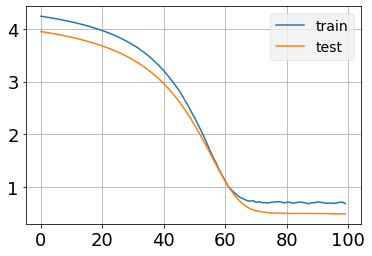

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.figsize=(10,8)
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
dfz = df.loc[3711:,:]
dfz = dfz[['date_m','ALLSKY_SFC_SW_DWN']]
ms_predict = model_simple.predict(X_testT)
dfz['ms'] = ms_predict
dfz = round(dfz,3)
dfz = dfz.set_index('date_m')
dfz.head(2)

,ALLSKY_SFC_SW_DWN,ms
date_m,,
2023-03-01,5.39,4.247
2023-03-02,4.48,4.327


Result Metrics for Model_Simple_LSTM Codajas
R2_Score :  0.113
Mean Squared Error :  1.353
Mean Absolute Error :  0.891
Mean Absolute Percentage Error :  35.572
Execution_Time:  35.38


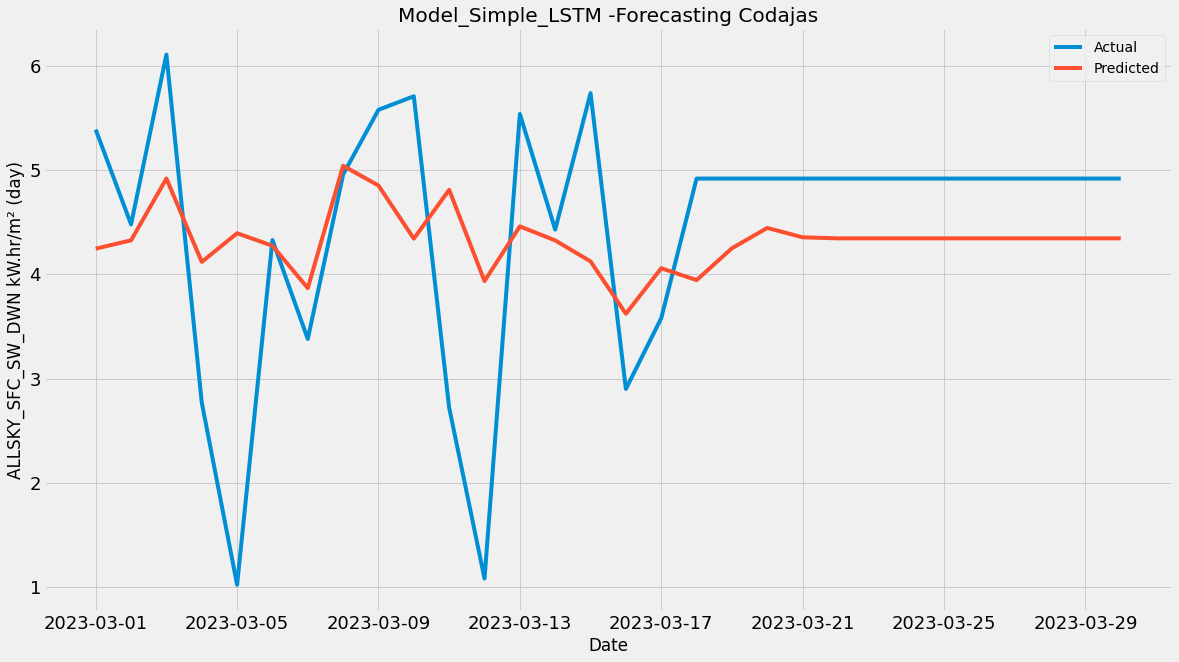

In [ ]:
result_metrics_forecast(dfz['ALLSKY_SFC_SW_DWN'],dfz['ms'],'Model_Simple_LSTM',time_ms,station)

In [ ]:
w = pd.DataFrame()

In [ ]:
w = result_output_forecast(dfz['ALLSKY_SFC_SW_DWN'],dfz['ms'],'Model_Simple_LSTM',time_ms,station,w)
w

Codajas Model_Simple_LSTM 0.113 35.572 1.353 0.891 35.38
Empty DataFrame
Columns: [Station, predict_model, R²_score, MAPE, MSE, MAE, Time_interval]
Index: []


,Station,predict_model,R²_score,MAPE,MSE,MAE,Time_interval


### GRU_model

In [ ]:
# Forecasting Using GRU(Gated Re-current Unit)
# GRU is simply a improved version of standard Re-current Neural Network(RNN) with two gates(update & reset).

In [ ]:
gc.collect()

6096

In [ ]:
gru_start = time.time()

In [ ]:
global gru_model
gru_model = Sequential()
# Layer 1 of GRU with Dropout
gru_model.add(GRU(units=30, return_sequences=True,
                input_shape=(X_trainT.shape[1], X_trainT.shape[2]), activation='tanh'))
gru_model.add(Dropout(0.2))
# Layer 2 of GRU with Dropout
gru_model.add(GRU(units=30, return_sequences=True,
                input_shape=(X_trainT.shape[1], X_trainT.shape[2]), activation='tanh'))
gru_model.add(Dropout(0.2))
# Layer 3 of GRU with Dropout
gru_model.add(GRU(units=30, return_sequences=True,
                input_shape=(X_trainT.shape[1], X_trainT.shape[2]), activation='tanh'))
gru_model.add(Dropout(0.2))
# Layer 4 of GRU with Dropout
gru_model.add(GRU(units=30, activation='tanh'))
gru_model.add(Dropout(0.2))
# Output layer of GRU model
gru_model.add(Dense(units=1))
#compiling the model
#compiling the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
gru_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = gru_model.fit(X_trainT, y_train, epochs= 60, batch_size=36, validation_data=(X_testT, y_test), verbose=2, shuffle=False)
# gru_model.compile(optimizer='adam',loss='mean_squared_error')
# gru_model.fit(X_trainT, y_train, epochs=50, batch_size=32)

Train on 3711 samples, validate on 30 samples
Epoch 1/60
 - 2s - loss: 4.2342 - mae: 4.7342 - val_loss: 3.9452 - val_mae: 4.4452
Epoch 2/60
 - 0s - loss: 4.2259 - mae: 4.7258 - val_loss: 3.9373 - val_mae: 4.4373
Epoch 3/60
 - 0s - loss: 4.2174 - mae: 4.7174 - val_loss: 3.9290 - val_mae: 4.4290
Epoch 4/60
 - 0s - loss: 4.2080 - mae: 4.7080 - val_loss: 3.9201 - val_mae: 4.4201
Epoch 5/60
 - 0s - loss: 4.1982 - mae: 4.6982 - val_loss: 3.9104 - val_mae: 4.4104
Epoch 6/60
 - 0s - loss: 4.1872 - mae: 4.6872 - val_loss: 3.8998 - val_mae: 4.3998
Epoch 7/60
 - 0s - loss: 4.1752 - mae: 4.6752 - val_loss: 3.8881 - val_mae: 4.3881
Epoch 8/60
 - 0s - loss: 4.1619 - mae: 4.6619 - val_loss: 3.8753 - val_mae: 4.3752
Epoch 9/60
 - 0s - loss: 4.1470 - mae: 4.6470 - val_loss: 3.8610 - val_mae: 4.3609
Epoch 10/60
 - 0s - loss: 4.1315 - mae: 4.6315 - val_loss: 3.8452 - val_mae: 4.3450
Epoch 11/60
 - 0s - loss: 4.1124 - mae: 4.6124 - val_loss: 3.8276 - val_mae: 4.3274
Epoch 12/60
 - 0s - loss: 4.0928 - mae:

In [ ]:
gru_stop = time.time()

In [ ]:
gru_time = gru_stop - gru_start

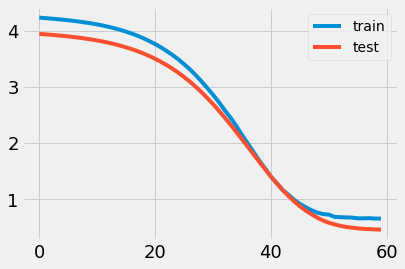

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.figsize=(10,8)
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.legend()
plt.show()

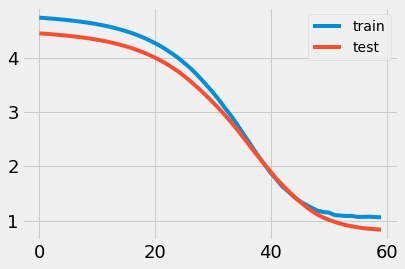

In [ ]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.figsize=(10,8)
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
gru_predict = gru_model.predict(X_testT)
a = pd.DataFrame()
a['y_test'] = y_test
a['gru_predict'] = gru_predict
a = round(a,3)

In [ ]:
test.head(2)

,ALLSKY_SFC_SW_DWN,T2M_1,RH2M_1,WS10M_1,ALLSKY_KT_1
date_m,,,,,
2023-03-01,5.39,26.19,90.00,0.96,0.48
2023-03-02,4.48,26.39,89.88,0.86,0.48


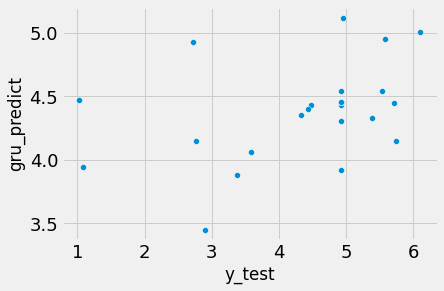

In [ ]:
sns.scatterplot(data = a, x = 'y_test', y ='gru_predict')
plt.figsize=(10, 8)
plt.style.use('fivethirtyeight')
plt.grid(True)
# plt.show()

In [ ]:
dfa = df.loc[3711:,:]
dfa = dfa[['date_m','ALLSKY_SFC_SW_DWN']]
dfa['gru'] = gru_predict
dfa = round(dfa,3)
dfa = dfa.set_index('date_m')
dfa.head(2)

,ALLSKY_SFC_SW_DWN,gru
date_m,,
2023-03-01,5.39,4.326
2023-03-02,4.48,4.433


Result Metrics for GRU_LSTM Codajas
R2_Score :  0.142
Mean Squared Error :  1.309
Mean Absolute Error :  0.833
Mean Absolute Percentage Error :  34.656
Execution_Time:  24.209


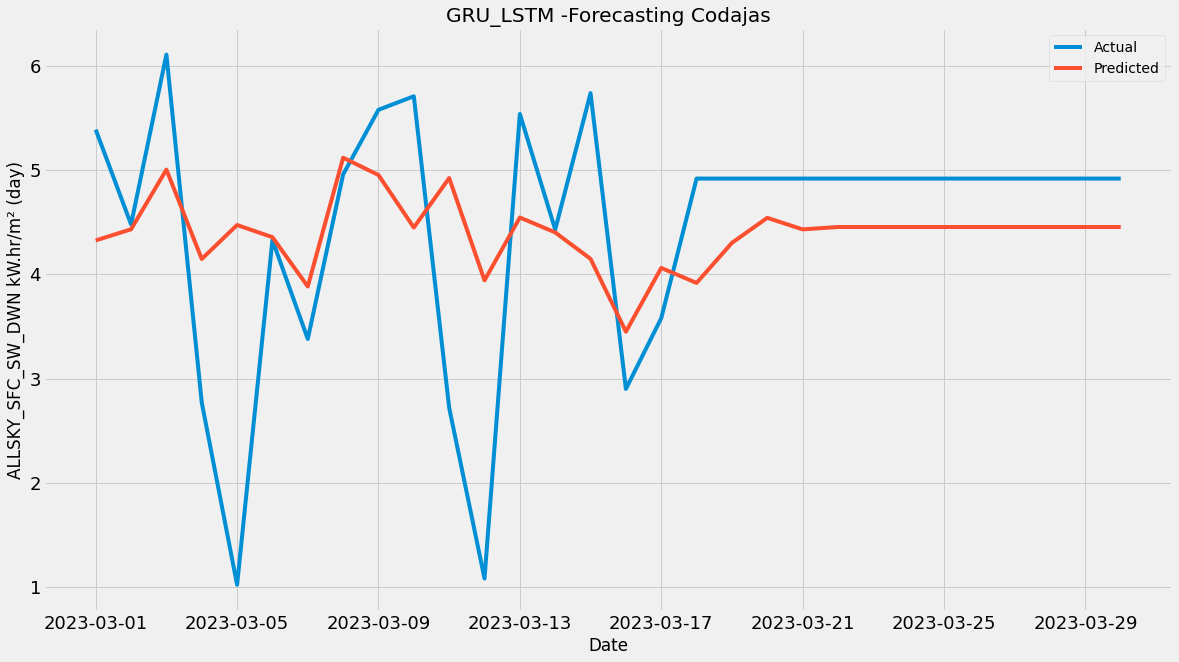

In [ ]:
result_metrics_forecast(dfa['ALLSKY_SFC_SW_DWN'],dfa['gru'],'GRU_LSTM', gru_time,station)

In [ ]:
w2 = pd.DataFrame()

In [ ]:
w2 = result_output_forecast(dfa['ALLSKY_SFC_SW_DWN'],dfa['gru'],'GRU_LSTM',gru_time,station,w2)
w2

Codajas GRU_LSTM 0.142 34.656 1.309 0.833 24.209
Empty DataFrame
Columns: [Station, predict_model, R²_score, MAPE, MSE, MAE, Time_interval]
Index: []


,Station,predict_model,R²_score,MAPE,MSE,MAE,Time_interval
